In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  model.png  sample_data


In [2]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from sklearn.model_selection import train_test_split

In [3]:
CSV_HEADER = ['label', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11',
      'I12', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
      'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22',
      'C23', 'C24', 'C25', 'C26']

In [4]:
file = '/content/drive/MyDrive/ColabNotebooks/RS/DeepFM/data/dac_sample.txt'
df = pd.read_csv(file, sep='\t', header=None, names=CSV_HEADER)

In [5]:
train_data, test_data = train_test_split(df, test_size=0.1)

In [6]:
train_data.head()

label   I1  I2     I3    I4  ...  C22       C23       C24       C25       C26
2851       1  0.0   0    1.0   2.0  ...  NaN  32c7478e       NaN       NaN       NaN
44959      1  4.0  21  294.0   8.0  ...  NaN  423fab69  b258af68       NaN       NaN
76525      0  2.0   1    1.0   NaN  ...  NaN  423fab69  8b8725c1  cb079c2d  a8740a4a
50030      1  NaN  -1    NaN   NaN  ...  NaN  32c7478e  42998020  e8b83407  2bf605fd
89666      0  8.0   2   38.0  10.0  ...  NaN  bcdee96c  3fdb382b  9b3e8820  49d68486

[5 rows x 40 columns]

In [7]:
train_data_file = "/content/drive/MyDrive/ColabNotebooks/RS/wide_deep_model/data/train_data.csv"
test_data_file = "/content/drive/MyDrive/ColabNotebooks/RS/wide_deep_model/data/test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

In [8]:
TARGET_FEATURE_NAME = "label"

TARGET_FEATURE_LABELS = ["0", "1"]

NUMERIC_FEATURE_NAMES = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 
             'I8', 'I9', 'I10', 'I11','I12', 'I13']

CATEGORICAL_FEATURE_NAMES = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
      'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22',
      'C23', 'C24', 'C25', 'C26']
# 类别特征字典
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    str(cate) : [str(elem) for elem in df[cate].unique()] for cate in CATEGORICAL_FEATURE_NAMES
    }

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0.] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

In [9]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()

In [10]:
learning_rate = 0.001
dropout_rate = 0.5
batch_size = 1024
num_epochs = 5

hidden_units = [64, 32]

In [11]:
def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

In [12]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [13]:
from tensorflow.keras.layers.experimental import preprocessing

def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    embedding_dims = 8
    
    for feature_name in inputs:
        # 分别处理类别特征和数值特征
        if feature_name in CATEGORICAL_FEATURE_NAMES:  
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert string values to an integer indices. 编码字符类型
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = preprocessing.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=1,
                output_mode="int" if use_embedding else "binary", # binary使用one-hot编码
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                # embedding_dims = int(math.sqrt(len(vocabulary)))
                
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim = len(vocabulary) + 1, output_dim = embedding_dims
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
                encoded_feature = tf.expand_dims(encoded_feature, 1)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], 1)) 
        else:
            if use_embedding:
              encoded_feature = tf.expand_dims(inputs[feature_name], -1)
              encoded_feature = layers.BatchNormalization()(encoded_feature) 
              encoded_feature = layers.Dense(embedding_dims)(encoded_feature) # 数值特征映射到embedding_dims做交叉
              encoded_feature = tf.expand_dims(encoded_feature, 1)
            else:
              encoded_feature = tf.expand_dims(inputs[feature_name], -1) 

        encoded_features.append(encoded_feature)
        
    if use_embedding:
      return encoded_features
    all_features = layers.concatenate(encoded_features)
    return all_features


In [14]:
class FM(Layer):
    """
    Wide part
    """

    def __init__(self):
        """
        Factorization Machine
        In DeepFM, only the first order feature and second order feature intersect are included.
        :param feature_length: A scalar. The length of features.
        :param w_reg: A scalar. The regularization coefficient of parameter w.
        """
        super(FM, self).__init__()
        self.first_order_layer = layers.Dense(1, activation = 'sigmoid')

    def call(self, inputs, **kwargs):
        """
        :param inputs: A dict with shape `(batch_size, {'sparse_inputs', 'embed_inputs'})`:
          fea_index is 2D tensor with shape `(batch_size, sum(field_num))` # 
          fea_embed is 3D tensor with shape `(batch_size, fields, embed_dim)` # 
        """
        wide_inputs, deep_inputs = inputs
        deep_inputs = layers.Concatenate(axis=1)(deep_inputs)

        # first order 一次项，线性模型
        first_order = self.first_order_layer(wide_inputs)  # (batch_size, 1)

        # second order 二次项，二阶交叉项
        square_sum = tf.square(tf.reduce_sum(deep_inputs, axis=1, keepdims=True))  # (batch_size, 1, embed_dim)
        sum_square = tf.reduce_sum(tf.square(deep_inputs), axis=1, keepdims=True)  # (batch_size, 1, embed_dim)
        second_order = 0.5 * tf.reduce_sum(square_sum - sum_square, axis=2)  # (batch_size, 1)

        return first_order + second_order

In [15]:
def create_deep_and_fm_model():

    inputs = create_model_inputs()
    wide_inputs = encode_inputs(inputs)
    deep_inputs = encode_inputs(inputs, use_embedding=True) # 深度部分

    fm_outputs = FM()([wide_inputs, deep_inputs])
    
    deep_inputs = tf.squeeze(layers.concatenate(deep_inputs, axis = 2), axis = 1)
    for units in hidden_units:
        deep = layers.Dense(units)(deep_inputs)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([fm_outputs, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_fm_model = create_deep_and_fm_model()
keras.utils.plot_model(deep_and_fm_model, show_shapes=True, rankdir="LR")

In [16]:
history = run_experiment(deep_and_fm_model)

Start training the model...
Epoch 1/5
88/88 [==============================] - 14s 77ms/step - loss: 0.5929 - sparse_categorical_accuracy: 0.7451
Epoch 2/5
88/88 [==============================] - 5s 55ms/step - loss: 0.4605 - sparse_categorical_accuracy: 0.7951
Epoch 3/5
88/88 [==============================] - 5s 54ms/step - loss: 0.3615 - sparse_categorical_accuracy: 0.8462
Epoch 4/5
88/88 [==============================] - 5s 53ms/step - loss: 0.2725 - sparse_categorical_accuracy: 0.8874
Epoch 5/5
88/88 [==============================] - 5s 55ms/step - loss: 0.2242 - sparse_categorical_accuracy: 0.9060
Model training finished
Test accuracy: 78.0%


In [17]:
keys_list = list(history.history.keys())

In [18]:
keys_list

['loss', 'sparse_categorical_accuracy']

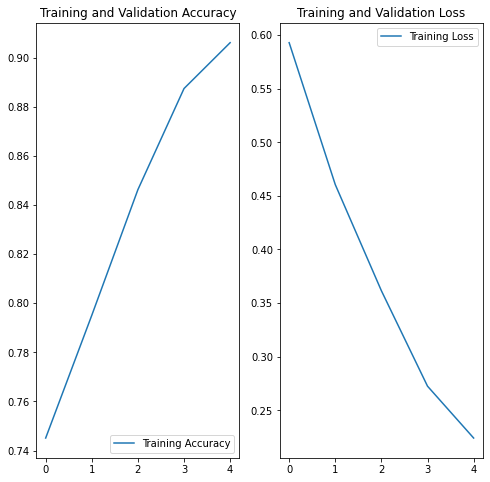

In [19]:
import matplotlib.pyplot as plt

acc = history.history[keys_list[1]]
loss = history.history[keys_list[0]]

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()